# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_set, y_train_set = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
import numpy as np

# TODO: Number of training examples
n_train = len(X_train_set)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train_set[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = max(np.append(y_train_set, y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 42


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.


Class to explore 0
Train data count is 210
Test data count is 60
Max image value 255
Min image value 53

Class to explore 1
Train data count is 2220
Test data count is 720
Max image value 173
Min image value 36

Class to explore 2
Train data count is 2250
Test data count is 750
Max image value 255
Min image value 75

Class to explore 3
Train data count is 1410
Test data count is 450
Max image value 87
Min image value 14

Class to explore 4
Train data count is 1980
Test data count is 660
Max image value 73
Min image value 34

Class to explore 5
Train data count is 1860
Test data count is 630
Max image value 255
Min image value 9

Class to explore 6
Train data count is 420
Test data count is 150
Max image value 152
Min image value 23

Class to explore 7
Train data count is 1440
Test data count is 450
Max image value 194
Min image value 12

Class to explore 8
Train data count is 1410
Test data count is 450
Max image value 71
Min image value 13

Class to explore 9
Train data count is 1470

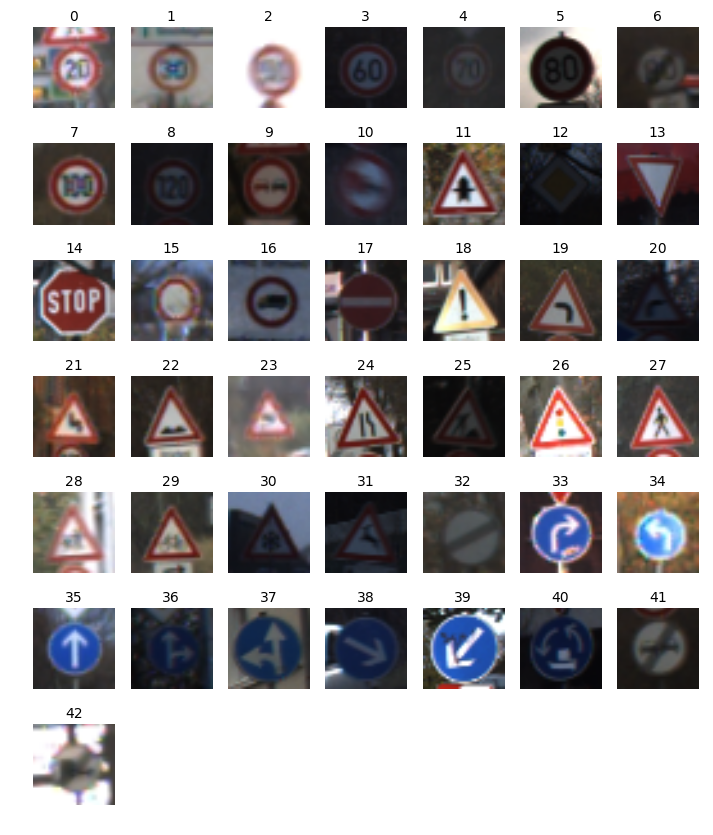

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(bottom=-0.3, left=0.025, top = 1.0, right=0.975)
for class_value in range(0, n_classes + 1):
    train_class = [X_train_set[index] for index, value in enumerate(y_train_set) if value == class_value]
    test_class = [X_test[index] for index, value in enumerate(y_test) if value == class_value]
    
    print()
    print("Class to explore", class_value)
    print("Train data count is", len(train_class))
    print("Test data count is", len(test_class))
    
    index = random.randint(0, len(train_class))
    image = train_class[index]
    
    subplot = plt.subplot(8, 7, 1 + class_value)
    subplot.imshow(image)
    subplot.axis('off')
    subplot.set_title(class_value, fontsize = 10)
    print("Max image value", np.max(image))
    print("Min image value", np.min(image))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
from sklearn.utils import shuffle
import tensorflow as tf

tf.reset_default_graph()
INPUT_DEPTH = 1

x = tf.placeholder(tf.float32, (None, 32, 32, INPUT_DEPTH))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
learning_rate = tf.placeholder(tf.float32)

with tf.device('/cpu:0'):
    one_hot_y = tf.one_hot(y, n_classes)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

Additional validation set of 25% percentage from every class from training set was extracted randomly to improve generalization. 

I played with different preprocessed techniques using Lenet architecture. I inverstigated the folllowing:
1. grayscale
2. extract H layer of HSV
3. extract Y layer of YUV
4. histogram equalization
5. image normalization (-1,1)
6. data augmentaion (affine transformation, motion blur, rotation, change brightness)

The results are below. Data augmentaion did not bring any improvments as H, Y layers and grayscale.
Some benefits show histogram equalization (makes sense since some pictures are extremaly dark) and normalization as expected. So, only **histogram equalization and normalization** are left (*data augmentsion is left for reference and not used*)

*Update*: My final measure was to increase convolutional layer sizes. Seems they are too small to keep all info. Wasn't successful either. Then I introduce L2 regularization and got an amazing performance boost! According to Andrej Karpathy's lecture https://www.youtube.com/watch?v=qlLChbHhbg4&t=2107s it makes sense to use L2 regularization to force **all** your parameters to work.

PS. I still have a large room for improvement since I have to play with all preprocessing, augmentaion and architectures but now along with L2 regularization

*Preprocessing results (over LeNet atchitecture)*

**Unchanged data**

    EPOCH 3: 0.883, EPOCH 10: 0.183
**H layer from HSV**

    EPOCH 6: = 0.875, EPOCH 10: 0.143
**Y layer from YUV**

    EPOCH 3: 0.906, EPOCH 10: 0.235
**Normalization of unchanged data**(the slowest overfit)

    EPOCH 2: 0.889, EPOCH 10: 0.624
**Normalization of Y**

    EPOCH 3: 0.908, EPOCH 10: 0.580
**Normalization of H** (slowly overfit!)

    EPOCH 3: 0.849, EPOCH 10: 0.375

**Histogram equalization**

    EPOCH 4: 0.856, EPOCH 10: 0.212
    
**Histogram equalization of H**

    EPOCH 4: 0.891, EPOCH 10: 0.213    
    
**Histogram equalization of Y**

    EPOCH 4: 0.895, EPOCH 10: 0.193 
    
**Augmentation with affin transformation**

    EPOCH 2: 0.675, EPOCH 10: 0.092
    
**Dropout before logits**

    EPOCH 16: 0.960
    
**Dropout after the first FC**

    EPOCH 10: 0.862, 20: 0.086
    
**Dropout after both FC**

    EPOCH 27: 0.881, 35: 0.061

*Data augmentation*

In [5]:
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import cv2

def change_brightness(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = np.random.randint(10,50)
    value_layer = image_hsv[:,:,2]
    image_hsv[:,:,2] = np.maximum(value_layer - random_bright, np.zeros(value_layer.shape))
    return cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)

def rotate_image(img):
    rotation_angle = np.random.randint(5,15)
    rows,cols,ch = img.shape    
    rotation_matrix = cv2.getRotationMatrix2D((cols/2,rows/2), rotation_angle, 1)
    return cv2.warpAffine(img, rotation_matrix, (cols,rows))  

def affine_transformation(img):
    deviation = np.random.randint(-3,3)
    
    rows,cols,ch = img.shape
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pts2 = np.float32([[1,10+deviation],[20-deviation,5],[10,30-deviation]])
           
    #translate to stay inside the frame
    M = np.float32([[1,0,-3],[0,1,-3]])
    img = cv2.warpAffine(img, M, (cols,rows))
    
    # scale to stay inside the frame
    rotation_matrix = cv2.getRotationMatrix2D((cols/2,rows/2), 0, 0.7)
    img = cv2.warpAffine(img, rotation_matrix, (cols,rows)) 
        
    M = cv2.getAffineTransform(pts1,pts2)
    return cv2.warpAffine(img,M,(cols,rows))   

def add_motion_blur(img):
    size = 3

    # generating the kernel
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size
    
    return cv2.filter2D(img, -1, kernel_motion_blur)

def generate_image(img):
    #while True:
    image_operations = np.random.randint(2,size=3)
    #    if (max(image_operations) == 1):
    #        break      
    if (image_operations[0] == 1):
        img = affine_transformation(img)
    else:
        img = rotate_image(img)
    if (image_operations[1] == 1):
        img = change_brightness(img)
    if (image_operations[2] == 1):
        img = add_motion_blur(img)
    return img

image = X_train_set[0]
print(X_train_set.shape)
for i in range(0, 5):
    new_image = generate_image(image)
    plt.figure()
    plt.imshow(new_image)

augmentation_level = 700

print(X_train_set.shape)
print(y_train_set.shape)

for class_value in range(0, n_classes + 1):
    train_class = [X_train_set[index] for index, value in enumerate(y_train_set) if value == class_value]
    print("class", class_value)
    if (len(train_class) < augmentation_level):
        to_train = augmentation_level - len(train_class)
        print("to train", to_train)
        image_per = int(to_train/len(train_class)) + 1
        for i in range(0, len(train_class)):
            base_image = train_class[i]
            for iteration in range(0, image_per):
                new_image = generate_image(base_image)
                X_train_set = np.concatenate((X_train_set, [new_image]), axis=0)
                y_train_set = np.append(y_train_set, class_value)
        print(X_train_set.shape)
        print(y_train_set.shape)
        
for class_value in range(0, n_classes + 1):
    train_class = [X_train_set[index] for index, value in enumerate(y_train_set) if value == class_value]
    
    print()
    print("Class to explore", class_value)
    print("Train data count is", len(train_class))

**Answer:**

In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [7]:
# Add validation set
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train_set, y_train_set, test_size=0.25,
                                                                random_state=42, stratify=y_train_set)

*Data preprocessing*

In [8]:
class Preprocessor:
    def __init__(self, operation):
        self.operation = operation
        
class PreprocessorInput(Preprocessor):
    def __init__(self, x):
        Preprocessor.__init__(self, x)
    def process(self):
        return self.operation
        
class ExtractHFromHSV(Preprocessor):
    def __init__(self, operation):
        Preprocessor.__init__(self, operation)
    def process(self):
        data = self.operation.process()
        return cv2.cvtColor(data, cv2.COLOR_BGR2HSV)[:,:,2:3]
    
class ExtractYFromYUV(Preprocessor):
    def __init__(self, operation):
        Preprocessor.__init__(self, operation)
    def process(self):
        data = self.operation.process()
        return cv2.cvtColor(data, cv2.COLOR_BGR2YUV)[:,:,0:1]
    
class Normalization(Preprocessor):
    def __init__(self, operation, a, b):
        Preprocessor.__init__(self, operation)
        self.a = a
        self.b = b
    def process(self):
        data = self.operation.process()
        data = data.astype(float)
        return self.a + (data*(self.b-self.a)/255)
    
class HistogramEqualization(Preprocessor):
    def __init__(self, operation):
        Preprocessor.__init__(self, operation)
    def process(self):
        data = self.operation.process()
        if (data.shape[2] == 1):
            data = np.expand_dims(cv2.equalizeHist(data), axis=2)
        else:
            img_yuv = cv2.cvtColor(data, cv2.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
            data = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        return data
    
class Grayscale(Preprocessor):
    def __init__(self, operation):
        Preprocessor.__init__(self, operation)
    def process(self):
        data = self.operation.process()
        return np.expand_dims(cv2.cvtColor(data, cv2.COLOR_BGR2GRAY), axis=2)

In [9]:
def preprocess_data(x):
    preprocessor_input = PreprocessorInput(x)
    
    #h_layer = ExtractHFromHSV(preprocessor_input)
    
    #h_layer = ExtractYFromYUV(preprocessor_input) 
    
    #equalized = HistogramEqualization(preprocessor_input)
    
    gray = Grayscale(preprocessor_input)
    
    normalized = Normalization(gray, -1.0, 1.0)
      
    return normalized.process()

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

I preprocessed data from all three sources: train, validation and test sets in the same way. No additaional data wre generated.*stratify* parameter of split works well enough

**Answer:**

Max image value 226
Min image value 18
Image shape (32, 32, 3)
Max image value 0.717647058824
Min image value -0.780392156863
Image shape (32, 32, 1)


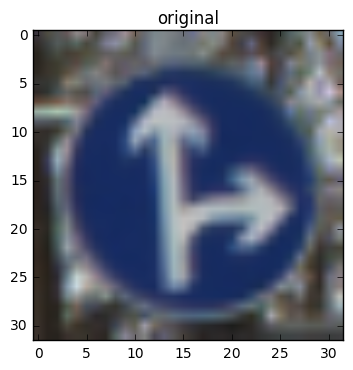

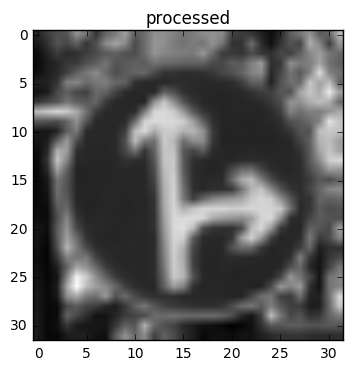

In [10]:
X_train_processed = []
X_validation_processed = []
X_test_processed = []

for sample in X_train:
    X_train_processed.append(preprocess_data(sample))
for sample in X_validation:
    X_validation_processed.append(preprocess_data(sample))
for sample in X_test:
    X_test_processed.append(preprocess_data(sample))

image = X_train[0]
print("Max image value", np.max(image))
print("Min image value", np.min(image))
print("Image shape", image.shape)
plt.figure()
plt.imshow(image)
plt.title("original")

image = X_train_processed[0]
print("Max image value", np.max(image))
print("Min image value", np.min(image))
print("Image shape", image.shape)
plt.figure()
if (len(image.shape) == 3 and image.shape[2] == 1):
    plt.imshow(image[:, :, 0], cmap='gray')
else:
    plt.imshow(image)
plt.title("processed")

**Answer:**

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


Pictures look pretty simple. Intuition says that we have simple shape in a lot of different combinations. So, we need three convolutional layers at least to develop more sophisticated features. Then we need fully connected layers. I decided to feed it with information from the last **two** convolutinal layers. Since amount of info is big two fully connected layers were chosen. Dropout was added before output layer to prevent overfitting.

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [12]:
from tensorflow.contrib.layers import flatten
    
class Layer:
    def __init__(self, layer):
        self.layer = layer
        
class Input(Layer):
    def __init(self, x):
        Layer.__init__(self, x)
    def build(self):
        return self.layer, 0
    
class Convolution2dRelu(Layer):
    def __init__(self, layer, weights_shape, bias_shape, mean, sigma, stride=1):
        Layer.__init__(self, layer)
        self.weights_shape = weights_shape
        self.bias_shape = bias_shape
        self.stride = stride
        self.mean = mean
        self.sigma = sigma
    def build(self):
        data, l2_loss = self.layer.build()
        weights = tf.Variable(tf.truncated_normal(shape=self.weights_shape, mean = self.mean, stddev = self.sigma))
        bias = tf.Variable(tf.zeros(self.bias_shape))
        conv = tf.nn.conv2d(data, weights, strides=[1, self.stride, self.stride, 1], padding='SAME')
        conv = tf.nn.bias_add(conv, bias)
        return tf.nn.relu(conv), l2_loss + tf.nn.l2_loss(weights)

class MaxPool2d(Layer):
    def __init__(self, layer, k=2):
        Layer.__init__(self, layer)
        self.k = k
    def build(self):
        data, l2_loss = self.layer.build()
        return tf.nn.max_pool(data, ksize=[1, self.k, self.k, 1], strides=[1, self.k, self.k, 1], padding='SAME'), l2_loss
    
class Flatten(Layer):
    def __init__(self, layer):
        Layer.__init__(self, layer)
    def build(self):
        data, l2_loss = self.layer.build()
        return flatten(data), l2_loss
    
class Combine(Layer):
    def __init__(self, layer1, layer2):
        Layer.__init__(self, layer1)
        self.layer2 = layer2
    def build(self):
        data1, l2_loss1 = self.layer.build()
        data2, l2_loss2 = self.layer2.build()
        return tf.concat(1, [data1, data2]), (l2_loss1 + l2_loss2)
    
class Linear(Layer):
    def __init__(self, layer, weights_shape, bias_shape, mean, sigma):
        Layer.__init__(self, layer)
        self.weights_shape = weights_shape
        self.bias_shape = bias_shape
        self.mean = mean
        self.sigma = sigma
    def build(self):
        data, l2_loss = self.layer.build()
        weights = tf.Variable(tf.truncated_normal(shape=self.weights_shape, mean = mu, stddev = sigma))
        bias = tf.Variable(tf.zeros(self.bias_shape))
        linear = tf.matmul(data, weights)
        return tf.nn.bias_add(linear, bias), (l2_loss + tf.nn.l2_loss(weights))

class LinearRelu(Linear):
    def __init__(self, layer, weights_shape, bias_shape, mean, sigma):
        Linear.__init__(self, layer, weights_shape, bias_shape, mean, sigma)
    def build(self):
        linear, l2_loss = Linear.build(self)
        return tf.nn.relu(linear), l2_loss
    
class Dropout(Layer):
    def __init__(self, layer):
        Layer.__init__(self, layer)
    def build(self):
        data, l2_loss = self.layer.build()
        return tf.nn.dropout(data, keep_prob), l2_loss

In [13]:
# Hyperparameters
mu = 0
sigma = 0.1

#layer_width = { 'l1': 6, 'l2': 16, 'fc1': 120, 'fc2': 84 }

layer_width = { 'l1': 32, 'l2': 64, 'l3': 128, 'fc1': 128, 'fc2': 90 }

def build_architecture(x, beta):
    input_x = Input(x)
    
    conv1 = Convolution2dRelu(input_x, (5, 5, INPUT_DEPTH, layer_width['l1']), [layer_width['l1']], mu, sigma)
    pooled1 = MaxPool2d(conv1)
    
    conv2 = Convolution2dRelu(pooled1, (5, 5, layer_width['l1'], layer_width['l2']),[layer_width['l2']], mu, sigma)
    pooled2 = MaxPool2d(conv2)
    
    #conv3 = Convolution2dRelu(pooled2, (3, 3, layer_width['l2'], layer_width['l3']),[layer_width['l3']], mu, sigma)
    #pooled3 = MaxPool2d(conv3)
    
    flat = Flatten(pooled2)
    
    #pooled2_2 = MaxPool2d(pooled2)
    #flat2 = Flatten(pooled2_2)
    
    #comb = Combine(flat1, flat2)
    
    fc1 = LinearRelu(flat, [8*8*layer_width['l2'], layer_width['fc1']], [layer_width['fc1']], mu, sigma)
    dropout1 = Dropout(fc1)
    
    #fc2 = LinearRelu(fc1, [layer_width['fc1'], layer_width['fc2']], [layer_width['fc2']], mu, sigma)  
    #dropout2 = Dropout(fc2)
    
    logits = Linear(dropout1, [layer_width['fc1'], n_classes], [n_classes], mu, sigma)
    
    data, l2_loss = logits.build()
    return data, beta*l2_loss

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


Initially learning rate was too high, so the model stopped converging too fast. Actually dropout help to converge the model. To improve accuracy the rate was decreased but I had to increase amount of epoches. If accuracy is not sufficient enough I can restore my model and continue training.

**Answer:**

In [14]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [15]:
class NeuralNetwork:
    def __init__(self, logits, one_hot_y, l2_loss, BATCH_SIZE, DROPOT_KEEP_PROP):
        self.BATCH_SIZE = BATCH_SIZE
        self.DROPOT_KEEP_PROP = DROPOT_KEEP_PROP
        self.logits = logits
        
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
        loss_operation = tf.reduce_mean(cross_entropy) + l2_loss
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = optimizer.minimize(loss_operation)
    def train(self, X_train, y_train, current_rate = 0.001):
        
        num_examples = len(X_train)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, self.BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(self.training_operation, feed_dict={x: batch_x, y: batch_y, learning_rate: current_rate,
                                                         keep_prob: self.DROPOT_KEEP_PROP})
    def top5predict(self, data):
        sess = tf.get_default_session()
        predictions = tf.nn.softmax(self.logits)
        return sess.run(tf.nn.top_k(predictions, k=5), feed_dict={x: data, keep_prob: 1.0})
    def predict(self, data):
        sess = tf.get_default_session()
        predictions = tf.nn.softmax(self.logits)
        return sess.run(tf.argmax(predictions, 1), feed_dict={x: data, keep_prob: 1.0})

In [16]:
class AccuracyMeasurement:
    def __init__(self, logits, one_hot_y, BATCH_SIZE):
        self.logits = logits
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        self.BATCH_SIZE = BATCH_SIZE
    def calculate_accuracy(self, X_data, y_data):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, self.BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

In [17]:
EPOCHS = 6
BATCH_SIZE = 128
rate = 0.001
DROPOT_KEEP_PROP = 0.5
BETA = 1e-4

In [18]:
logits, l2_loss = build_architecture(x, BETA)
network = NeuralNetwork(logits, one_hot_y, l2_loss, BATCH_SIZE, DROPOT_KEEP_PROP)
measurement = AccuracyMeasurement(logits, one_hot_y, BATCH_SIZE)

save_file = 'model/train_model.ckpt'

In [19]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_processed, y_train = shuffle(X_train_processed, y_train)
        network.train(X_train_processed, y_train, rate)
        
        train_accuracy = measurement.calculate_accuracy(X_train_processed, y_train)
        validation_accuracy = measurement.calculate_accuracy(X_validation_processed, y_validation)
        
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy*100))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy*100))
        print()
        
    saver.save(sess, save_file)
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 76.610
Validation Accuracy = 75.344

EPOCH 2 ...
Train Accuracy = 91.920
Validation Accuracy = 91.064

EPOCH 3 ...
Train Accuracy = 95.623
Validation Accuracy = 94.563

EPOCH 4 ...
Train Accuracy = 97.422
Validation Accuracy = 96.705

EPOCH 5 ...
Train Accuracy = 97.875
Validation Accuracy = 96.899

EPOCH 6 ...
Train Accuracy = 98.249
Validation Accuracy = 97.511

Model saved


In [20]:
EPOCHS = 10
rate = 0.00001

In [21]:
#continue training
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, save_file)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_processed, y_train = shuffle(X_train_processed, y_train)
        network.train(X_train_processed, y_train, rate)
        
        train_accuracy = measurement.calculate_accuracy(X_train_processed, y_train)
        validation_accuracy = measurement.calculate_accuracy(X_validation_processed, y_validation)
        
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy*100))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy*100))
        print()
        
    saver.save(sess, save_file)
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 98.609
Validation Accuracy = 97.939

EPOCH 2 ...
Train Accuracy = 98.653
Validation Accuracy = 97.970

EPOCH 3 ...
Train Accuracy = 98.711
Validation Accuracy = 98.031

EPOCH 4 ...
Train Accuracy = 98.725
Validation Accuracy = 98.072

EPOCH 5 ...
Train Accuracy = 98.735
Validation Accuracy = 98.041

EPOCH 6 ...
Train Accuracy = 98.738
Validation Accuracy = 98.082

EPOCH 7 ...
Train Accuracy = 98.772
Validation Accuracy = 98.082

EPOCH 8 ...
Train Accuracy = 98.776
Validation Accuracy = 98.103

EPOCH 9 ...
Train Accuracy = 98.776
Validation Accuracy = 98.092

EPOCH 10 ...
Train Accuracy = 98.772
Validation Accuracy = 98.113

Model saved


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Initially I thought that the pictures are pretty simple, so I can use pure convolutional layers with ReLU and stride=2 and discard maxpool step. It would decrease training time. Unfourtunately test set performance was poor, so I stick to maxpool. But still it is a good way to check your architecture quickly since speed is fast and performance result is relevant. Lenet architecture gave not bad results itself, so I have to invent something more informative. I tried to play with dropouts count(1 or 2) but seems one dropout gives the best result. I played with different preprocessing techniques but nothing gives visible results. I decided to play with additional convolutional layer and feed fully connected layer from two conv layers and played with different sizes of layers. Did not bring good results. I tries to increase the batch but the result performance was worse. Seems with small amoun of data for every class small batch is the best choice.

In [28]:
saver = tf.train.Saver()

# Launch the graph
with tf.Session() as sess:
    saver.restore(sess, save_file)

    test_accuracy = measurement.calculate_accuracy(X_test_processed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy*100))

Test Accuracy = 93.167


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [23]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

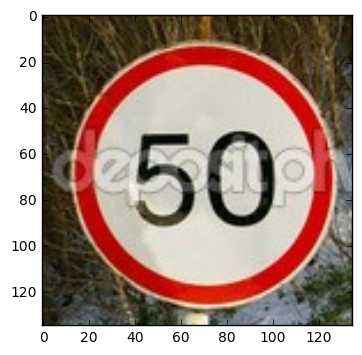

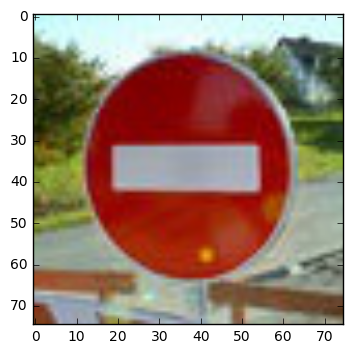

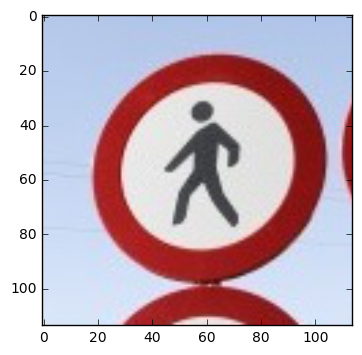

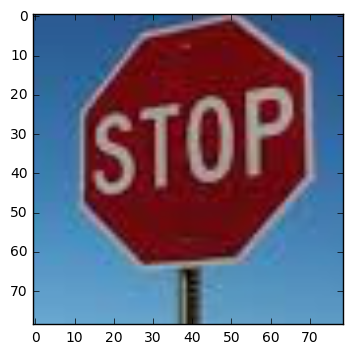

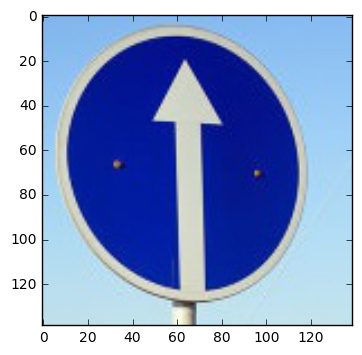

In [29]:
import os

for path in os.listdir("new_set/"):
    custom_image = mpimg.imread("new_set/" + path)

    plt.figure()
    plt.imshow(custom_image)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



Images are quite good quality, so it mmust be easy to identify them. But "Pedestrian" sign is different, round shape instead of triangle. One sign contains watermark what can lead to incorrect result

**Answer:**

In [30]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
resized_images = []
processed_images = []
y_custom = [2,17,27,14,35]

with tf.Session() as sess:
    saver.restore(sess, save_file)

    for path in os.listdir("new_set/"):
        custom_image = mpimg.imread("new_set/" + path)

        resized_image = cv2.resize(custom_image, (32,32))
        resized_images.append(resized_image)
    
    for sample in resized_images:
        processed_images.append(preprocess_data(sample))

    custom_accuracy = measurement.calculate_accuracy(processed_images, y_custom)
    print("Custom Accuracy = {:.3f}".format(custom_accuracy*100))

Custom Accuracy = 80.000


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [31]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, save_file)
    
    predictions = network.predict(processed_images)
    print("Predictions:", predictions)
    print("Correct result:", y_custom)

Predictions: [ 2 17  1 14 35]
Correct result: [2, 17, 27, 14, 35]


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

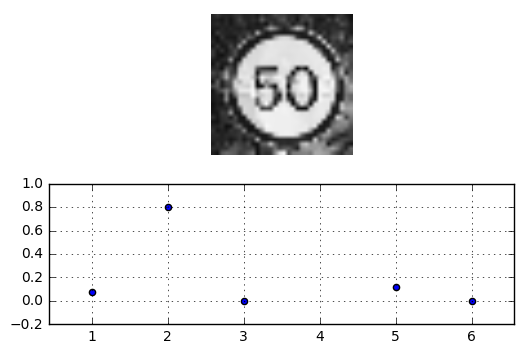

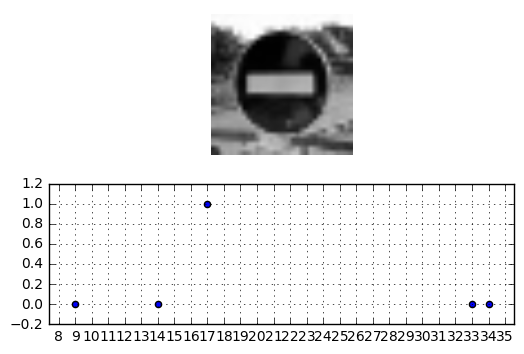

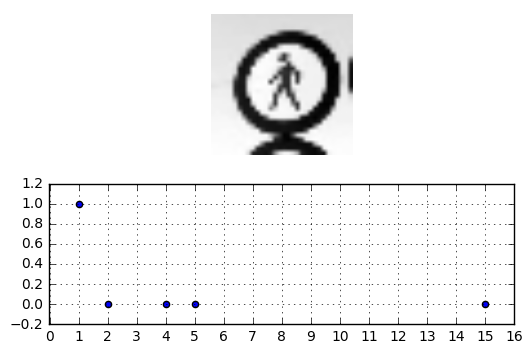

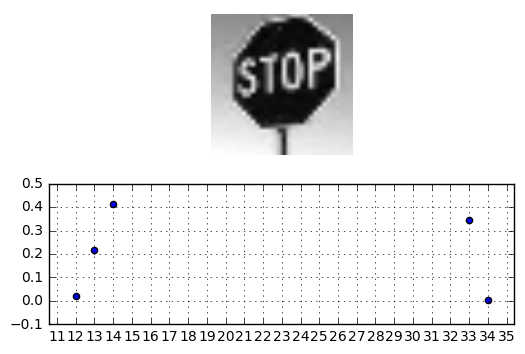

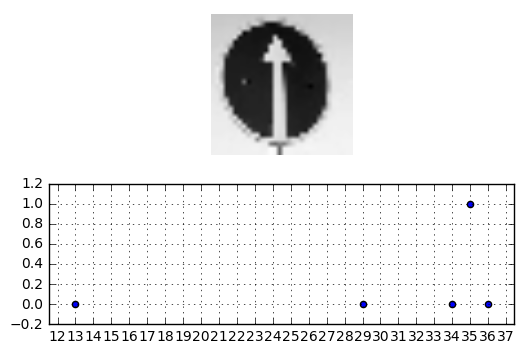

In [32]:
with tf.Session() as sess:
    saver.restore(sess, save_file)
    
    values, indices = network.top5predict(processed_images)
    for i in range(0,5):
        plt.figure()
        subplot = plt.subplot(2, 1, 1)
        if (len(processed_images[i].shape) == 3 and processed_images[i].shape[2] == 1):
            plt.imshow(processed_images[i][:, :, 0], cmap='gray')
        else:
            subplot.imshow(processed_images[i])
        subplot.axis('off')
        
        subplot = plt.subplot(2, 1, 2)
        plt.xticks(range(0,43))
        subplot.grid()
        subplot.scatter(indices[i], values[i])

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.